In [2]:
#Importing Libraries
import re
import string
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report, confusion_matrix
from wordcloud import WordCloud
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.svm import SVC

After importing the required libraries, we will read the data set to the program.

In [3]:
#Reading dataset
data = pd.read_csv('/content/fake_job_postings.csv')

#We will check the shape of the dataset and the top five elements of the dataset.
#Shape of the dataset
data.shape




#Head of the dataset
data.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In the head of the dataset, we can see that missing values are present as NaN. We will check all the missing values in the replace them with blank.

In [4]:
data.interpolate(inplace=True)
data.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [5]:
#Delete the unnecessary columns
columns=['job_id', 'telecommuting', 'has_company_logo', 'has_questions', 'salary_range', 'employment_type']
for col in columns:
    del data[col]

#Fill NaN values with blank space
data.fillna(' ', inplace=True)

data.head()

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


The data set is now free from the missing values. Now, we will check the total number of fraudulent postings and real postings.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,fraudulent,title
0,0,17014
1,1,866


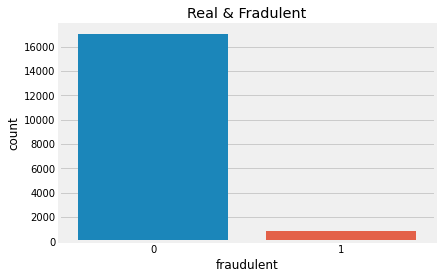

In [6]:
#Fraud and Real visualization
sns.countplot(data.fraudulent).set_title('Real & Fradulent')
data.groupby('fraudulent').count()['title'].reset_index().sort_values(by='title',ascending = False)

In the next step, we will visualize the number of job postings by countries and by experience. 


Text(0.5, 0, 'Countries')

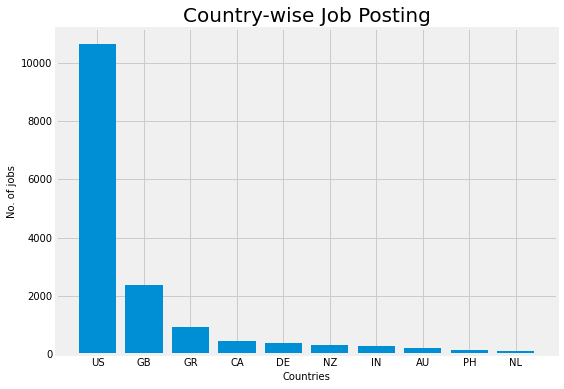

In [7]:
#Visualize job postings by countries
def split(location):
    l = location.split(',')
    return l[0]

data['country'] = data.location.apply(split)

country = dict(data.country.value_counts()[:11])
del country[' ']
plt.figure(figsize=(8,6))
plt.title('Country-wise Job Posting', size=20)
plt.bar(country.keys(), country.values())
plt.ylabel('No. of jobs', size=10)
plt.xlabel('Countries', size=10)

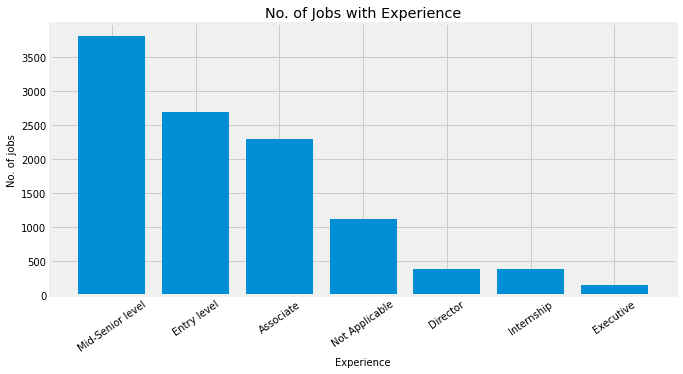

In [8]:
#Visualize the required experiences in the jobs
experience = dict(data.required_experience.value_counts())
del experience[' ']
plt.figure(figsize=(10,5))
plt.bar(experience.keys(), experience.values())
plt.title('No. of Jobs with Experience')
plt.xlabel('Experience', size=10)
plt.ylabel('No. of jobs', size=10)
plt.xticks(rotation=35)
plt.show()

Here, we will check the count of titles in all job postings, in fraudulent job postings and in real job postings.

In [9]:
#Most frequent jobs
print(data.title.value_counts()[:10])

English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
English Teacher Abroad (Conversational)                83
Customer Service Associate - Part Time                 76
Account Manager                                        75
Web Developer                                          66
Project Manager                                        62
Name: title, dtype: int64


In [10]:
#Titles and count of fraudulent jobs
print(data[data.fraudulent==1].title.value_counts()[:10])

Data Entry Admin/Clerical Positions - Work From Home                    21
Home Based Payroll Typist/Data Entry Clerks Positions Available         21
Cruise Staff Wanted *URGENT*                                            21
Customer Service Representative                                         17
Administrative Assistant                                                16
Home Based Payroll Data Entry Clerk Position - Earn $100-$200 Daily     12
Account Sales Managers $80-$130,000/yr                                  10
Network Marketing                                                       10
Payroll Clerk                                                           10
Payroll Data Coordinator Positions - Earn $100-$200 Daily               10
Name: title, dtype: int64


In [11]:
#Titles and count of real jobs
print(data[data.fraudulent==0].title.value_counts()[:10])

English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
English Teacher Abroad (Conversational)                83
Customer Service Associate - Part Time                 76
Account Manager                                        73
Web Developer                                          66
Project Manager                                        62
Name: title, dtype: int64


In the next step, the dataset will be preprocessed for training. For this purpose, all the important text data is combined in one column and rest are deleted except the target column.



In [12]:
#combine text in a single column to start cleaning our data
data['text']=data['title']+' '+data['location']+' '+data['company_profile']+' '+data['description']+' '+data['requirements']+' '+data['benefits']
del data['title']
del data['location']
del data['department']
del data['company_profile']
del data['description']
del data['requirements']
del data['benefits']
del data['required_experience']
del data['required_education']
del data['industry']
del data['function']
del data['country']
data.head()

,fraudulent,text
0,0,"Marketing Intern US, NY, New York We're Food52..."
1,0,"Customer Service - Cloud Video Production NZ, ..."
2,0,"Commissioning Machinery Assistant (CMA) US, IA..."
3,0,"Account Executive - Washington DC US, DC, Wash..."
4,0,"Bill Review Manager US, FL, Fort Worth SpotSou..."


To visualize the fraud and real job postings, the WordCloud is used to see the top occurring keywords in the data. To do so, fraud and real job postings are separated into two text files and WordCloud has plotted accordingly. 

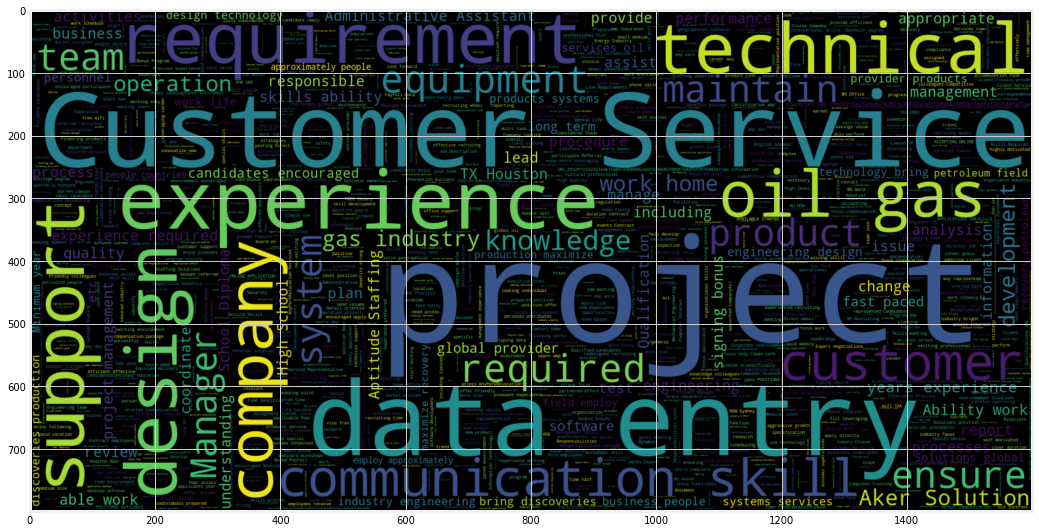

In [13]:
#Separate fraud and actual jobs
fraudjobs_text = data[data.fraudulent==1].text
actualjobs_text = data[data.fraudulent==0].text

#Fraudulent jobs word cloud
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(str(" ".join(fraudjobs_text)))
plt.imshow(wc,interpolation = 'bilinear')

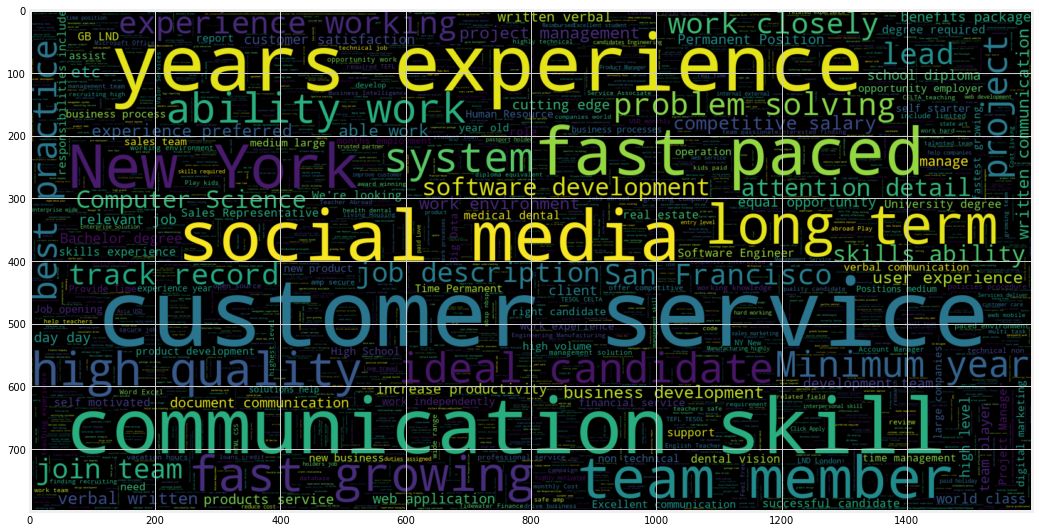

In [14]:
#Actual jobs wordcloud
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(str(" ".join(actualjobs_text)))
plt.imshow(wc,interpolation = 'bilinear')

The dataset is cleaned and preprocessed using the below lines of codes.

In [15]:
#Cleaning and preprocessing
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return a preprocessed list of tokens
    return mytokens

# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

# Splitting dataset in train and test
X_train, X_test, y_train, y_test = train_test_split(data.text, data.fraudulent, test_size=0.3)

#Train-test shape
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(12516,)
(12516,)
(5364,)
(5364,)


Once we are ready with the training and test data, we will train the machine learning model to classify the fraudulent and real job postings. In this task, we will use the Support Vector Classifier. The Pipeline is used to bind the cleaning, vectorization and classification works together.

In [16]:
#Support Vector Machine Classifier
# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,3))),
                 ('classifier', SVC())])

#Training the model.
pipe.fit(X_train,y_train)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7f7d29d2b7d0>),
                ('vectorizer',
                 CountVectorizer(ngram_range=(1, 3),
                                 tokenizer=<function spacy_tokenizer at 0x7f7d2814d170>)),
                ('classifier', SVC())])

Fake Job Classification

After successful training of the classifier, we will make predictions through it on the test data and obtain the accuracies by evaluation metrics. 

In [17]:
# Predicting with a test dataset
y_pred = pipe.predict(X_test)

# Model Accuracy
print("Classification Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report\n")
print(classification_report(y_test, y_pred))
print("Confusion Matrix\n")
print(confusion_matrix(y_test, y_pred))

Classification Accuracy: 0.9793064876957495
Classification Report

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5116
           1       1.00      0.55      0.71       248

    accuracy                           0.98      5364
   macro avg       0.99      0.78      0.85      5364
weighted avg       0.98      0.98      0.98      5364

Confusion Matrix

[[5116    0]
 [ 111  137]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


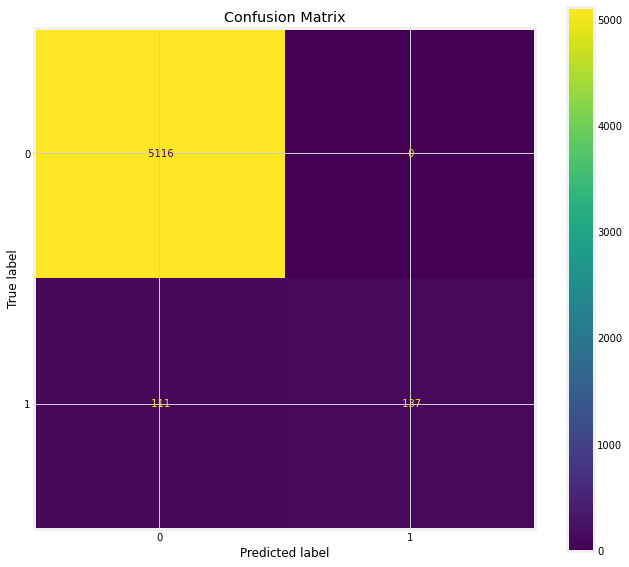

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(pipe, X_test, y_test, values_format=' ', ax=ax) 
plt.title('Confusion Matrix')
plt.show()

So, we can see that the Support Vector Classifier has given the accuracy score of 97.78% and for 5354 test observations, it has correctly predicted the class labels for 5245 job postings.